In [171]:
from glob import glob
import os, sys

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import pymannkendall

sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)
import open_ds
import utils
import warnings
warnings.filterwarnings('ignore')
import signal_to_noise as sn
import plotting_functions

import drift_functions
import sn_plotting

from importlib import reload

In [2]:
notebook_number = 'draft_06_zec'

In [3]:
os.listdir(constants.ZECMIP_LOCAL_REGRIDDED_DIR)

['esm-piControl',
 '1pct',
 'old',
 'A1',
 'landsea_mask.nc',
 'signal_to_noise',
 '.ipynb_checkpoints',
 'picontrol']

In [162]:
esm_picontrol_zec_da = open_ds.open_mfdataset_nc(os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, 'esm-piControl'), 
                                              to_array=False).tas.compute()

In [163]:
esm_picontrol_zec_da = esm_picontrol_zec_da-273.15

In [164]:
experiment_zec_da = open_ds.open_mfdataset_nc(os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, 'A1'), 
                                              to_array=False).tas.chunk('auto')

In [173]:
onepct_zec_da = open_ds.open_mfdataset_nc(os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, '1pct'),
                                             to_array=False).tas
refromer_giss_key_for_onepct = open_ds.reformat_giss_key_for_onepct(onepct_zec_da)

In [198]:
esm_picontrol_zec_smean_da = sn.calculate_global_value(esm_picontrol_zec_da, 'tas').compute()
esm_exp_zec_smean_da = sn.calculate_global_value(experiment_zec_da, 'tas').compute()
onepct_zec_da_smean = sn.calculate_global_value(onepct_zec_da, 'tas').compute()#.chunk('auto')

(None, None)
(None, None)
(None, None)


In [199]:
branch_point_mean_ds_smean = sn.calculate_branch_point_values(onepct_zec_da_smean)

In [200]:
esm_exp_zec_smean_anom_da = esm_exp_zec_smean_da - branch_point_mean_ds_smean

# Global Mean

In [252]:
import json

# Load branch point data from a JSON file
json_path = os.path.join(os.getcwd(), 'Documents', 'PhD', 'data', 'zecmip_onepercent_branch_point.json')
with open(json_path, 'r') as fp:
    zecmip_onepercent_branch_point = json.load(fp)

ds = onepct_zec_da_smean
# Initialize a list to store branch point mean datasets for each model
to_concat = []

# Iterate over each model in the dataset
for model in ds.model.values:
    # Select data for a single model
    single_model_ds = ds.sel(model=model)
    # Extract the start branch year for the current model
    start_branch_year = int(zecmip_onepercent_branch_point['branch_year'][model])
    # Calculate the mean of the data for a specific time range around the branch year
    start_branch_year = start_branch_year+1
    branch_mean_ds = single_model_ds.isel(time=slice(start_branch_year - 11, start_branch_year + 10)).mean(dim='time')
    # Append the branch point mean dataset to the list
    to_concat.append(branch_mean_ds)

# Concatenate all the branch point mean datasets along the model dimension
branch_point_mean_ds = xr.concat(to_concat, dim='model')

In [253]:
branch_mean_2 = esm_exp_zec_smean_da.isel(time=slice(19, 30)).mean(dim='time') - branch_point_mean_ds

In [254]:
branch_mean_2.to_pandas()

model
ACCESS-ESM1-5    -0.027901
CESM2            -0.111321
CanESM5          -0.029810
GFDL-ESM4        -0.102769
GISS-E2-1-G-CC   -0.064263
MIROC-ES2L       -0.096816
MPI-ESM1-2-LR    -0.207698
NorESM2-LM       -0.239959
UKESM1-0-LL       0.188840
dtype: float64

In [230]:
td = esm_exp_zec_smean_da.isel(time=slice(19, 30)).mean(dim='time') - branch_point_mean_ds_smean

In [231]:
td.to_pandas()

model
ACCESS-ESM1-5    -0.006204
CESM2            -0.094914
CanESM5          -0.010423
GFDL-ESM4        -0.092919
GISS-E2-1-G-CC   -0.045639
MIROC-ES2L       -0.087949
MPI-ESM1-2-LR    -0.192912
NorESM2-LM       -0.232123
UKESM1-0-LL       0.213873
dtype: float64

In [222]:
esm_exp_zec_smean_anom_da.isel(time=slice(19, 30)).mean(dim='time').to_pandas()

model
ACCESS-ESM1-5    -0.006204
CESM2            -0.094914
CanESM5          -0.010423
GFDL-ESM4        -0.092919
GISS-E2-1-G-CC   -0.045639
MIROC-ES2L       -0.087949
MPI-ESM1-2-LR    -0.192912
NorESM2-LM       -0.232123
UKESM1-0-LL       0.213873
dtype: float64

In [218]:
esm_exp_zec_smean_anom_da.isel(time=24).to_pandas()

model
ACCESS-ESM1-5    -0.224015
CESM2             0.032964
CanESM5           0.024040
GFDL-ESM4        -0.103127
GISS-E2-1-G-CC   -0.099595
MIROC-ES2L        0.088832
MPI-ESM1-2-LR    -0.258495
NorESM2-LM       -0.199316
UKESM1-0-LL       0.008735
dtype: float64

In [215]:
esm_exp_zec_smean_anom_da.isel(time=25).to_pandas()

model
ACCESS-ESM1-5    -0.069155
CESM2            -0.096581
CanESM5           0.136347
GFDL-ESM4        -0.148876
GISS-E2-1-G-CC   -0.238369
MIROC-ES2L        0.033537
MPI-ESM1-2-LR    -0.238123
NorESM2-LM       -0.273378
UKESM1-0-LL       0.237011
dtype: float64

<Axes: xlabel='model'>

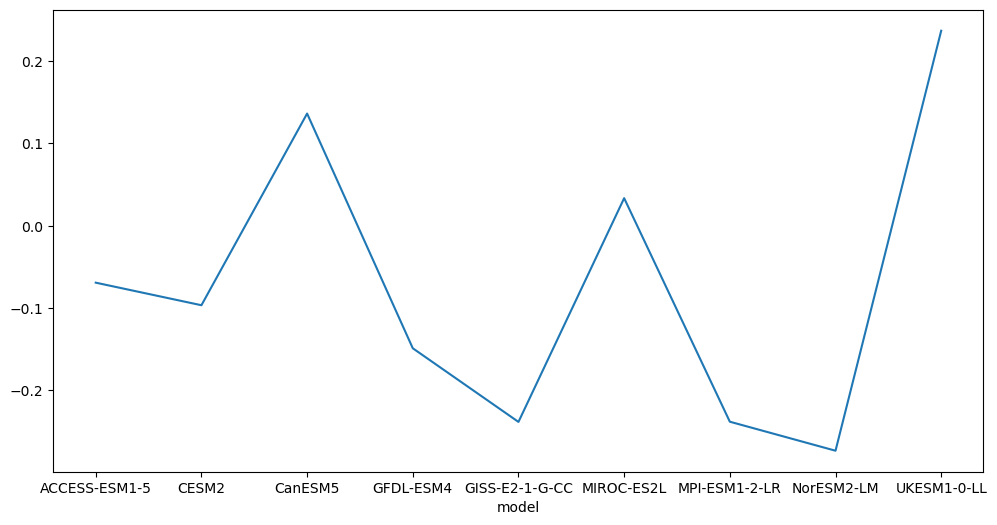

In [214]:
fig, ax = plt.subplots(figsize=(12,6))
esm_exp_zec_smean_anom_da.isel(time=25).to_pandas().plot()#.plot(x='model')

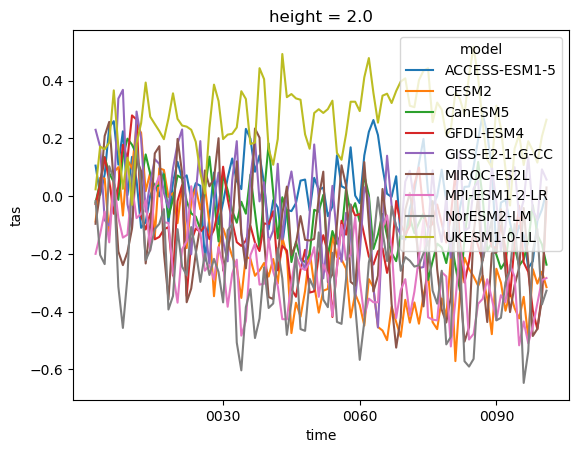

In [203]:
esm_exp_zec_smean_anom_da.plot(hue='model');

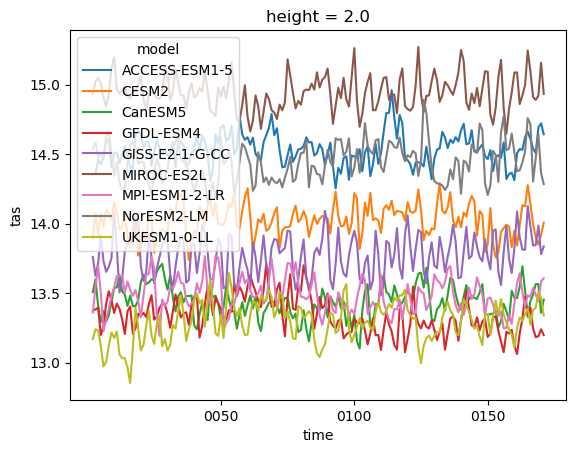

In [139]:
esm_picontrol_zec_smean_da.plot(x='time', hue='model');

/g/data/w40/ab2313/images/PhD/top_level/draft_06_zec_global_average_zec_model_drift_esm_picontrol.png


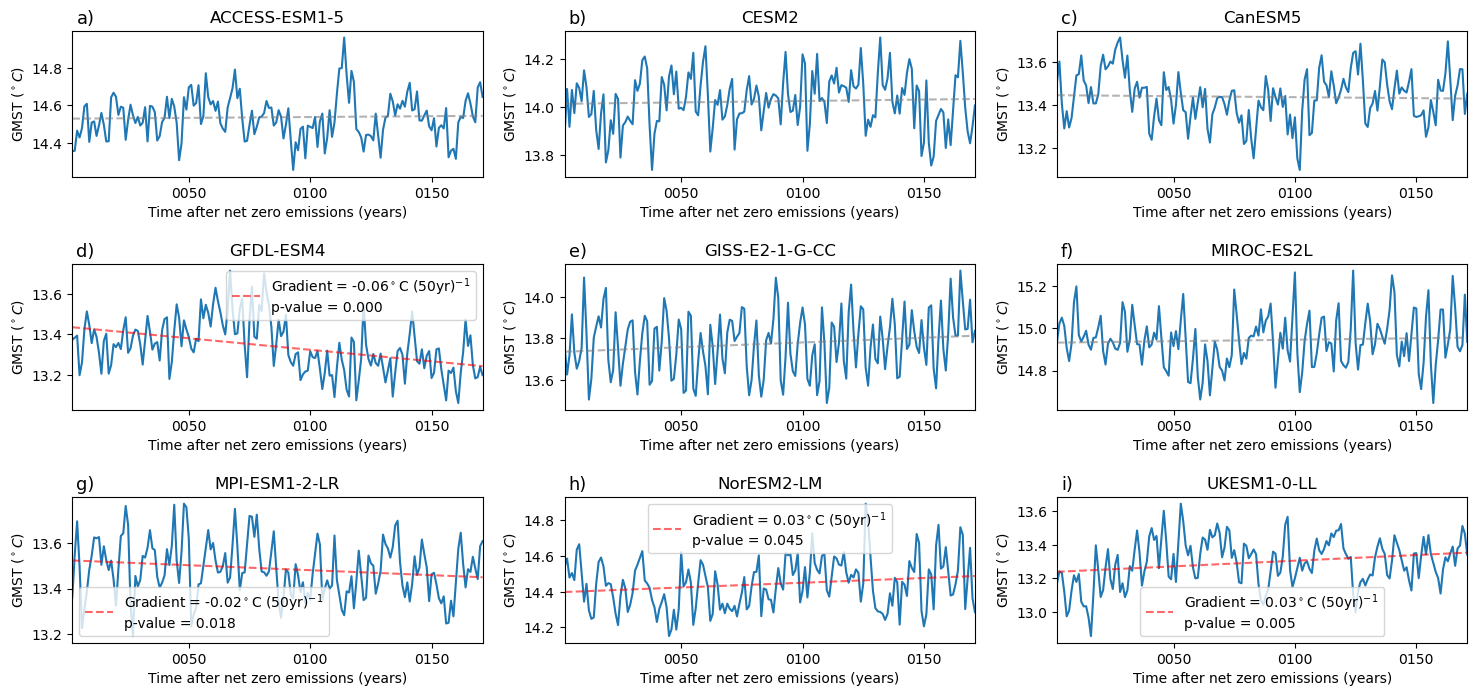

In [141]:
models = esm_picontrol_zec_smean_da.model.values
time = esm_picontrol_zec_smean_da.time.values
ncols = 3; nrows = int(np.ceil(len(models)/2))

fig = plt.figure(figsize=(18, 14))
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, hspace=0.6)

for num, model in enumerate(models):
    ax = fig.add_subplot(gs[num])
    plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=0.8)
    esm_picontrol_zec_smean_da.sel(model=model).plot(ax=ax)
    ax.set_title(model); ax.set_ylabel(r'GMST $(^\circ C)$'); ax.set_xlabel('Time after net zero emissions (years)')
    ax.set_xlim([time[0], time[-1]])
    init_y = esm_picontrol_zec_smean_da.sel(model=model).values

    x = np.arange(len(init_y))

    grad_yint = np.polyfit(x, init_y, deg=1)

    fitted_line = np.polyval(grad_yint, x)
    mk_val = pymannkendall.original_test(init_y)
    mk_pval = mk_val.p
    if mk_pval < 0.05:
        color = 'red'
        label = f'Gradient = {grad_yint[0]*50:.2f}' + r'$^\circ$C (50yr)$^{-1}$' + f'\np-value = {mk_pval:.3f}'
    else:
        color='grey'
        label=None
    
    ax.plot(time, fitted_line, linestyle='--', alpha=0.6, color=color, label=label)
    if mk_pval < 0.05:
        ax.legend(ncol=1, loc='best')#bbox_to_anchor=(0.6, 1.06))
        
        
save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_global_average_zec_model_drift_esm_picontrol.png')
print(save_name)
fig.savefig(save_name, dpi=300, bbox_inches='tight')

# Local Gradient and p-value

In [11]:
pi_pval_da = drift_functions.calculate_pvals(esm_picontrol_zec_da.isel(time=slice(0, 100)))
exp_pval_da = drift_functions.calculate_pvals(experiment_zec_da)


KeyboardInterrupt



In [ ]:
# Just the p-values that are less tha 0.05
pi_sig_da = xr.where(pi_pval_da < 0.05, 1, np.nan)
exp_sig_da = xr.where(exp_pval_da < 0.05, 1, np.nan)

In [ ]:
# Calculating the gradient over the 100 year run length
gradient_exp_full_da = drift_functions.calculate_trend(experiment_zec_da);
gradient_pi_full_da = drift_functions.calculate_trend(esm_picontrol_zec_da.isel(time=slice(0, 100)))

In [ ]:
# Multiplying gradient by 50 to get K per 50 years
gradient_exp_full_da = (gradient_exp_full_da*50).persist()
gradient_pi_full_da = (gradient_pi_full_da*50).persist()

In [ ]:
gradient_full_diff = gradient_exp_full_da-gradient_pi_full_da

In [ ]:
# Can remove all the models that don't have esm-piControl simulations
gradient_exp_full_da = gradient_exp_full_da.sel(model=gradient_pi_full_da.model.values)

In [ ]:
# All mean value plots
models = gradient_full_diff.model.values
nrows = len(models); ncols = 3
fig = plt.figure(figsize=(6*ncols, 8*ncols))
gs = gridspec.GridSpec(nrows+1, ncols, height_ratios = [1]*nrows +[0.2], hspace=.2, wspace=0)
projection = ccrs.Robinson(central_longitude=int(np.mean(gradient_full_diff.lon.values)))

drift_plot_levels = np.arange(-1.4, 1.4, .2)
drift_plot_kwargs = dict(levels=drift_plot_levels, extend='both', cmap='RdBu_r', add_label=False, font_scale=0.7)
vm =40; step=5; levels_mean_stab2 = np.arange(0, vm+step, step)
all_axes = []

### A1

fig, gs, axes1 = sn_plotting.map_plot_all_for_coords_2(
    gradient_exp_full_da, dim='model',
    fig=fig, gs=gs, add_colorbar=False, stipling_da=exp_sig_da,
    axes = [fig.add_subplot(gs[i, 0], projection=projection) for i in range(len(models))],
    **drift_plot_kwargs)

for num, (ax, model) in enumerate(zip(axes1, models)):
    # ax.set_ylabel(model, labelpad=500)
    # sn_plotting.plot_stippled_data(pi_sig_da.sel(model=model), ax) # TODO: This is not working in the `map_plot_all_for_coords_2` function
    if num == 0: ax.set_title('A1 Experiment', fontsize=constants.PlotConfig.title_size*drift_plot_kwargs['font_scale'])
    else: ax.set_title('')
    
y_axis_kwargs = dict(xy=(-.25, 0.5), ha='center', va='center', xycoords='axes fraction', rotation=0,
                     size=constants.PlotConfig.title_size*drift_plot_kwargs['font_scale'])
for model, ax in zip(models, axes1): ax.annotate(model, **y_axis_kwargs)
all_axes.extend(axes1)


#### Pi-control

fig, gs, axes2 = sn_plotting.map_plot_all_for_coords_2(
    gradient_pi_full_da, dim='model',
    fig=fig, gs=gs, add_colorbar=False,stipling_da=pi_sig_da, 
    axes = [fig.add_subplot(gs[i, 1], projection=projection) for i in range(len(models))],
    **drift_plot_kwargs)
for ax in axes2: ax.set_title('')
axes2[0].set_title('ESM Pre-Industrial Control', size=constants.PlotConfig.title_size*drift_plot_kwargs['font_scale'])

all_axes.extend(axes2)

### Diff

fig, gs, axes3 = sn_plotting.map_plot_all_for_coords_2(
    gradient_full_diff, dim='model',
     cbar_title="Gradient (K /(50 year))", fig=fig, gs=gs,
    axes = [fig.add_subplot(gs[i, 2], projection=projection) for i in range(len(models))],
    cax = plt.subplot(gs[nrows, :]), 
    **drift_plot_kwargs)
for ax in axes3: ax.set_title('')
axes3[0].set_title('Difference', size=constants.PlotConfig.title_size*drift_plot_kwargs['font_scale'])
all_axes.extend(axes3)

for num, ax in enumerate(all_axes): plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=0.7)

save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_zec_local_model_drift_esm_picontrol.png')
print(save_name)
fig.savefig(save_name, dpi=500, bbox_inches='tight')

# Parallel Period Comparison

## Global Average

In [12]:
# esm_picontrol_zec_smean_da
# esm_exp_zec_smean_da

In [13]:
def calculate_anomalies_from_base_period(da:xr.DataArray, base_period:int=20) -> xr.DataArray:
    # The anomalies should be calculated compared to the first 20 years.
    base_period_ds = da.isel(time=slice(None, base_period)).mean(dim='time')
    # Anomalies 
    anomalies_ds = da.isel(time=slice(base_period, None)).rolling(time=20, center=True).mean().dropna(dim='time') - base_period_ds
    return anomalies_ds

In [14]:
picontrol_smean_anomalies_da = calculate_anomalies_from_base_period(esm_picontrol_zec_smean_da)
exp_smean_anomalies_da = calculate_anomalies_from_base_period(esm_exp_zec_smean_da)

In [15]:
anomly_smean_difference = exp_smean_anomalies_da - picontrol_smean_anomalies_da

(array([14.,  9., 23., 16., 14., 11.,  5., 19., 15.,  5.]),
 array([0.12818116, 0.14418471, 0.16018827, 0.17619183, 0.19219538,
        0.20819894, 0.22420249, 0.24020605, 0.2562096 , 0.27221316,
        0.28821672]),
 <BarContainer object of 10 artists>)

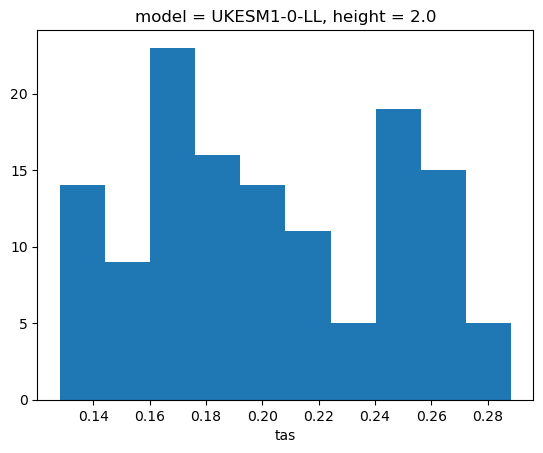

In [16]:
picontrol_smean_anomalies_da.sel(model=model).plot.hist()

In [17]:
bins = np.arange(-.5, .5, .02)

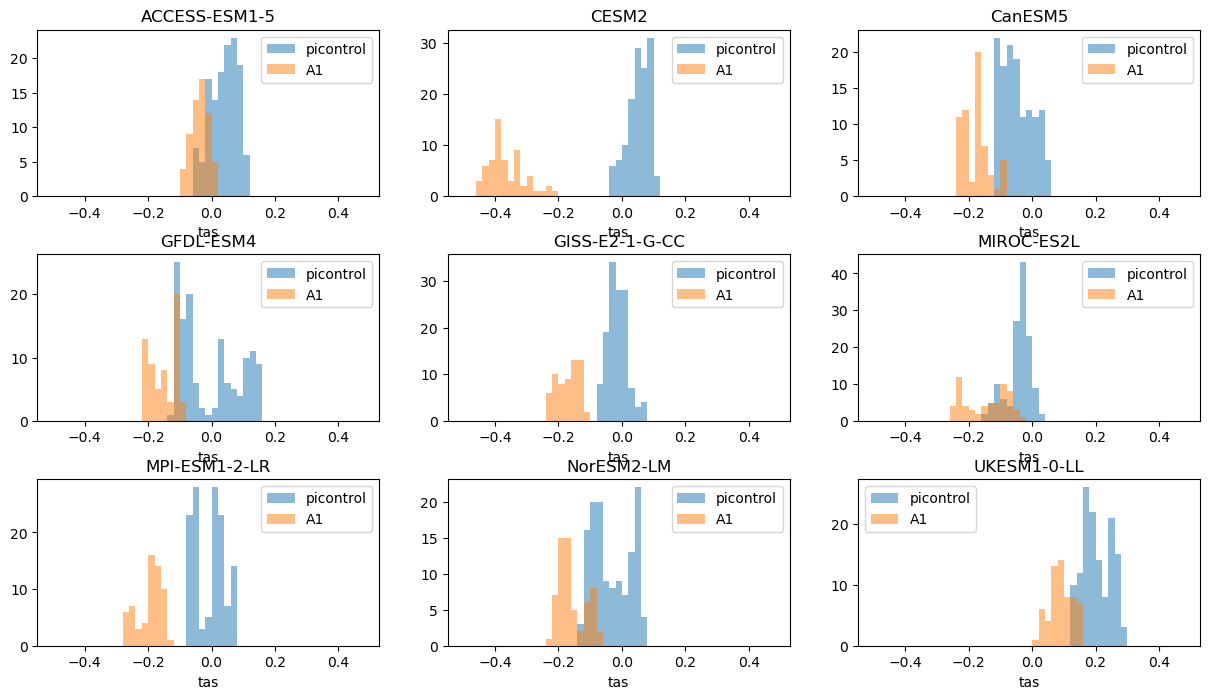

In [18]:
models = picontrol_smean_anomalies_da.model.values
fig = plt.figure(figsize=(15, 8))
ncols = 3
nrows = int(np.ceil(len(models)/ncols))
gs = gridspec.GridSpec(nrows, ncols, hspace=.35)

axes = [fig.add_subplot(gs[i]) for i in range(nrows* ncols)]
for ax, model in zip(axes, models):
    picontrol_smean_anomalies_da.sel(model=model).plot.hist(ax=ax, bins=bins, alpha=.5, label='picontrol');
    exp_smean_anomalies_da.sel(model=model).plot.hist(ax=ax, bins=bins, alpha=.5, label='A1')
    ax.set_title(model)
    ax.legend()

# ZEC anomly period analysis

In [255]:
zec_da = esm_exp_zec_smean_da.isel(time=slice(25, 45)).mean(dim='time') - esm_exp_zec_smean_da.isel(time=slice(None, 20)).mean(dim='time')
zec_da = zec_da.compute()
zec_da

<xarray.DataArray 'tas' (model: 9)>
array([-0.04325982, -0.2837407 , -0.10524348, -0.1394579 , -0.12944274,
       -0.0565555 , -0.1869045 , -0.1877959 ,  0.08028721])
Coordinates:
  * model    (model) object 'ACCESS-ESM1-5' 'CESM2' ... 'UKESM1-0-LL'
    height   float64 2.0

In [308]:
# esm_picontrol_rolling_da = esm_picontrol_zec_smean_da.isel(time=slice(20, None)).rolling(time=20).mean(dim='time')
# esm_picontrol_zec_da = esm_picontrol_rolling_da - esm_picontrol_base_da

In [309]:
# Slice from start until final 25
esm_pi_control_slice1 = esm_picontrol_zec_smean_da.isel(time=slice(None, time_length-25))
# Slice from year 25 until end
esm_pi_control_slice2 = esm_picontrol_zec_smean_da.isel(time=slice(25, None))

# 20 year rolling mean with dropping na time
esm_pi_control_slice1_rolling = esm_pi_control_slice1.rolling(time=20).mean(dim='time').dropna(dim='time')
esm_pi_control_slice2_rolling = esm_pi_control_slice2.rolling(time=20).mean(dim='time').dropna(dim='time')

esm_pi_control_zec25_np = esm_pi_control_slice1_rolling.values - esm_pi_control_slice1_rolling.values

esm_pi_control_zec25 = xr.zeros_like(esm_picontrol_zec_smean_da.isel(time=slice(None, len(esm_pi_control_slice1_rolling.time.values))))
esm_pi_control_zec25 += esm_pi_control_zec25_np

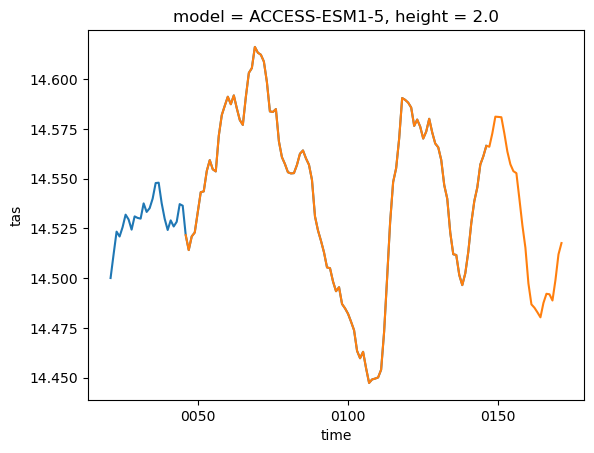

In [319]:
esm_pi_control_slice1_rolling.isel(model=0).plot()
esm_pi_control_slice2_rolling.isel(model=0).plot()

In [310]:
bound = .21
step = .01
bins = np.arange(-bound, bound+step, step)

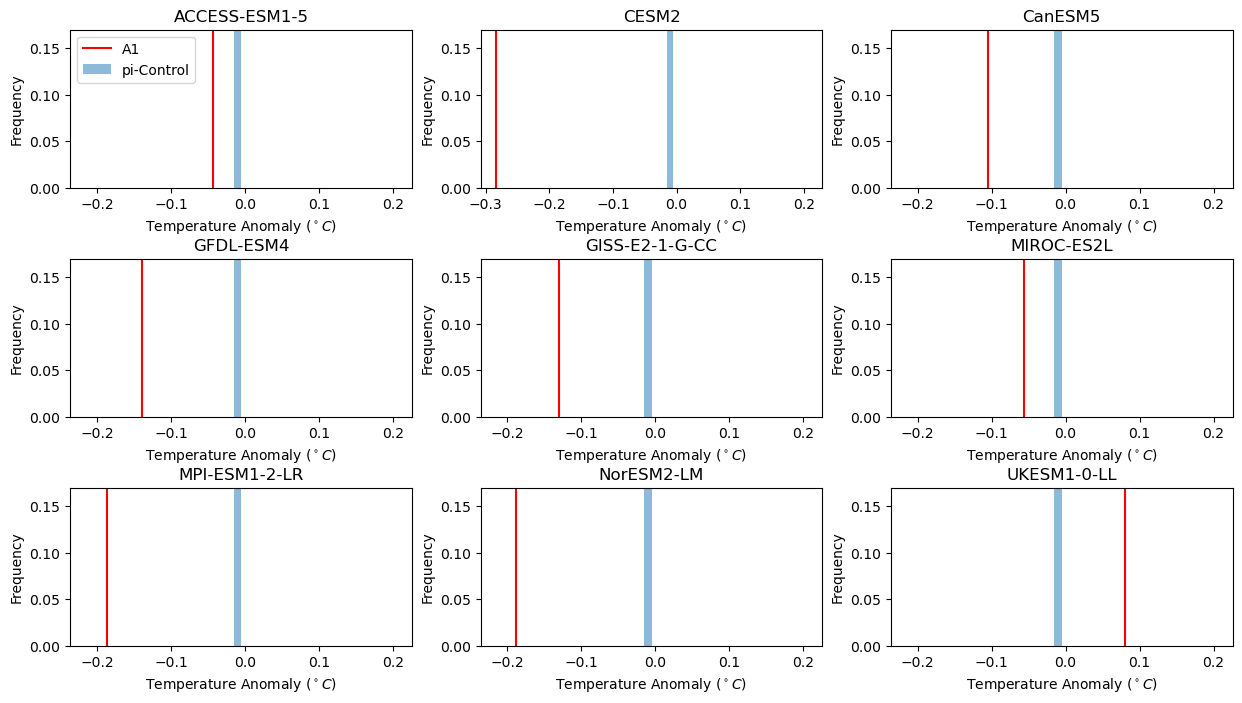

In [312]:
models = esm_pi_control_zec25.model.values
fig = plt.figure(figsize=(15, 8))
ncols = 3
nrows = int(np.ceil(len(models)/ncols))
gs = gridspec.GridSpec(nrows, ncols, hspace=.45)

axes = [fig.add_subplot(gs[i]) for i in range(nrows* ncols)] 
for num, (ax, model) in enumerate(zip(axes, models)):
    vals = esm_pi_control_zec25.sel(model=model).dropna(dim='time')
    #n, bins, patches = ax.hist(vals.values, bins=bins, alpha=.5, label='pi-Control') #  density=True, stacked=True
    hist, edges = np.histogram(vals.values, bins=bins, density=True)
    nsum = len(vals.time.values)#$np.sum(hist)
    ax.bar(edges[:-1], hist/nsum, alpha=.5, width=step, label='pi-Control')
    zec_single_model = zec_da.sel(model=model).values
    ax.axvline(zec_single_model, 0, 1, color='red', label=r'A1')
    ax.set_title(f'{model}')#(n={int(nsum)})')
    ax.set_ylim(0, .17)
    ax.set_xlabel(r'Temperature Anomaly ($^\circ C$)'); ax.set_ylabel('Frequency')
    if not num: ax.legend(loc='upper left')
# fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, 'draft_06_zec_disctribution_comparison.png'), dpi=400, bbox_inches='tight')